In [ ]:
!pip install torch torchvision matplotlib tqdm numpy pandas google-colab pytorch_lightning 1> /dev/null

In [ ]:
#!pip install --upgrade pytorch-pretrained-vit 1> /dev/null
#!pip install vit-pytorch 1> /dev/null
!pip install timm 1> /dev/null

In [ ]:
!nvidia-smi

Mon Jul  3 14:20:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content/drive/MyDrive/UTP/FYP
!pwd

/content/drive/MyDrive/UTP/FYP
/content/drive/MyDrive/UTP/FYP


In [ ]:
# import csv
# csv_fields = ['fold','epoch','train_losses','train_acc','val_losses','val_acc','lr']
# with open('./data/pwc_ViT_timm_pure_k_folds.csv', 'a', newline='') as fd:
#   writer = csv.writer(fd)
#   writer.writerow(csv_fields)

In [ ]:
import os
import math
import torch
import tarfile
import matplotlib
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, ConcatDataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import csv

%matplotlib inline

In [ ]:
# Model Hyperparameters
#"Input has shape `(batch_size, seq_len, emb_dim)`"
batch_size = 8 # 8 is maximum
learning_rate = 0.0005

In [ ]:
# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Using device: cuda


In [ ]:
# Look into the data directory
data_dir = './data/pwcdata'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['NC', 'ASD']


In [ ]:
# Data transforms (normalization & data augmentation)
stats = (0.5, 0.5)
train_tfms = tt.Compose([#tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         #tt.Resize((384, 384)),
                         tt.RandomHorizontalFlip(),
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
train_ds_size = int(len(train_ds) * 0.8)
valid_ds_size = len(train_ds) - train_ds_size
train_ds, valid_ds = random_split(train_ds, [train_ds_size, valid_ds_size])
dataset = ConcatDataset([train_ds, valid_ds])

# PyTorch data loaders (moved to k-fold cv)
# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=False)
# valid_dl = DataLoader(valid_ds, batch_size, shuffle=True, num_workers=1, pin_memory=False)

# Move data loaders to device (moved to k-fold cv)
# train_dl = DeviceDataLoader(train_dl, device)
# valid_dl = DeviceDataLoader(train_dl, device)

## Image Classification Methods

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# ViT Model

In [ ]:
model = timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k', pretrained=False, num_classes=2)
#model = torch.load('./data/pwc_ViT_timm_pure_5_folds')
to_device(model, device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# K-fold Cross Validator
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for fold, (train_ids, valid_ids) in enumerate(kfold.split(dataset)):
  print(f'Fold : {fold+1+5} Start\n')
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

  train_dl = torch.utils.data.DataLoader(
                    dataset, batch_size, num_workers=1,
                    pin_memory=False, sampler=train_subsampler)
  valid_dl = torch.utils.data.DataLoader(
                    dataset, batch_size, num_workers=1,
                    pin_memory=False, sampler=valid_subsampler)

  train_dl = DeviceDataLoader(train_dl, device)
  valid_dl = DeviceDataLoader(train_dl, device)

  epochs = 3
  train_losses = np.zeros(epochs)
  val_losses = np.zeros(epochs)
  train_accs = np.zeros(epochs)
  val_accs = np.zeros(epochs)

  for epoch in range(epochs):
    csv_fields = np.zeros(7)
    torch.cuda.empty_cache()
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_dl):
      data = data
      label = label

      output = model(data)
      loss = criterion(output, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      acc = (output.argmax(dim=1) == label).float().mean()
      epoch_accuracy += acc / len(train_dl)
      epoch_loss += loss / len(train_dl)

    train_accs[epoch] = epoch_accuracy
    train_losses[epoch] = epoch_loss

    with torch.no_grad():
      epoch_val_accuracy = 0
      epoch_val_loss = 0
      for data, label in valid_dl:
        data = data
        label = label

        val_output = model(data)
        val_loss = criterion(val_output, label)

        acc = (val_output.argmax(dim=1) == label).float().mean()
        epoch_val_accuracy += acc / len(valid_dl)
        epoch_val_loss += val_loss / len(valid_dl)

    val_accs[epoch] = epoch_val_accuracy
    val_losses[epoch] = epoch_val_loss
    csv_fields[0] = fold+1+5
    csv_fields[1] = epoch
    csv_fields[2] = f'{epoch_loss:.4f}'
    csv_fields[3] = f'{epoch_accuracy:.4f}'
    csv_fields[4] = f'{epoch_val_loss:.4f}'
    csv_fields[5] = f'{epoch_val_accuracy:.4f}'
    csv_fields[6] = f'{learning_rate:.4f}'
    with open('./data/pwc_ViT_timm_pure_k_folds.csv', 'a', newline='') as fd:
        writer = csv.writer(fd)
        writer.writerow(csv_fields)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - lr: {learning_rate:.4f}\n"
    )
  print(f'Fold : {fold+1+5} End\n')

Fold : 6 Start



100%|██████████| 1024/1024 [04:45<00:00,  3.58it/s]


Epoch : 1 - loss : 0.1346 - acc: 0.9540 - val_loss : 0.1215 - val_acc: 0.9607 - lr: 0.0005



100%|██████████| 1024/1024 [04:45<00:00,  3.59it/s]


Epoch : 2 - loss : 0.1139 - acc: 0.9604 - val_loss : 0.0816 - val_acc: 0.9752 - lr: 0.0005



100%|██████████| 1024/1024 [04:45<00:00,  3.59it/s]


Epoch : 3 - loss : 0.1271 - acc: 0.9579 - val_loss : 0.1012 - val_acc: 0.9629 - lr: 0.0005

Fold : 6 End

Fold : 7 Start



100%|██████████| 1024/1024 [04:45<00:00,  3.59it/s]


Epoch : 1 - loss : 0.1076 - acc: 0.9611 - val_loss : 0.1287 - val_acc: 0.9563 - lr: 0.0005



100%|██████████| 1024/1024 [04:44<00:00,  3.60it/s]


Epoch : 2 - loss : 0.1000 - acc: 0.9667 - val_loss : 0.0893 - val_acc: 0.9677 - lr: 0.0005



100%|██████████| 1024/1024 [04:44<00:00,  3.60it/s]


Epoch : 3 - loss : 0.1074 - acc: 0.9598 - val_loss : 0.1618 - val_acc: 0.9569 - lr: 0.0005

Fold : 7 End

Fold : 8 Start



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 1 - loss : 0.1026 - acc: 0.9653 - val_loss : 0.0771 - val_acc: 0.9712 - lr: 0.0005



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 2 - loss : 0.1134 - acc: 0.9614 - val_loss : 0.1025 - val_acc: 0.9612 - lr: 0.0005



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 3 - loss : 0.0944 - acc: 0.9642 - val_loss : 0.1067 - val_acc: 0.9596 - lr: 0.0005

Fold : 8 End

Fold : 9 Start



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 1 - loss : 0.0805 - acc: 0.9716 - val_loss : 0.0671 - val_acc: 0.9774 - lr: 0.0005



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 2 - loss : 0.0825 - acc: 0.9725 - val_loss : 0.0712 - val_acc: 0.9785 - lr: 0.0005



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 3 - loss : 0.1090 - acc: 0.9636 - val_loss : 0.0880 - val_acc: 0.9680 - lr: 0.0005

Fold : 9 End

Fold : 10 Start



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 1 - loss : 0.0942 - acc: 0.9677 - val_loss : 0.0695 - val_acc: 0.9761 - lr: 0.0005



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 2 - loss : 0.0801 - acc: 0.9736 - val_loss : 0.0608 - val_acc: 0.9797 - lr: 0.0005



100%|██████████| 1024/1024 [04:43<00:00,  3.61it/s]


Epoch : 3 - loss : 0.2126 - acc: 0.9110 - val_loss : 0.1953 - val_acc: 0.9237 - lr: 0.0005

Fold : 10 End



In [ ]:
model_save_path = f'./data/pwc_ViT_timm_pure_{fold+1+5}_folds'
torch.save(model, model_save_path)
!cat ./data/pwc_ViT_timm_pure_k_folds.csv

fold,epoch,train_losses,train_acc,val_losses,val_acc,lr
1.0,0.0,0.3009,0.8938,0.1965,0.934,0.0005
1.0,1.0,0.2041,0.9263,0.135,0.9475,0.0005
1.0,2.0,0.2054,0.9258,0.3691,0.8914,0.0005
2.0,0.0,0.1397,0.9484,0.0977,0.9656,0.0005
2.0,1.0,0.2417,0.8964,0.6758,0.5101,0.0005
2.0,2.0,0.6543,0.6031,0.4331,0.8773,0.0005
3.0,0.0,0.2939,0.8794,0.2663,0.9116,0.0005
3.0,1.0,0.2644,0.8961,0.1629,0.9459,0.0005
3.0,2.0,0.1822,0.9346,0.1565,0.9415,0.0005
4.0,0.0,0.1643,0.9415,0.1376,0.9484,0.0005
4.0,1.0,0.2847,0.8547,0.3248,0.8929,0.0005
4.0,2.0,0.2256,0.9116,0.502,0.7101,0.0005
5.0,0.0,0.2332,0.9081,0.1663,0.9329,0.0005
5.0,1.0,0.1535,0.9421,0.1212,0.9565,0.0005
5.0,2.0,0.1531,0.9437,0.1961,0.9318,0.0005
6.0,0.0,0.1346,0.954,0.1215,0.9607,0.0005
6.0,1.0,0.1139,0.9604,0.0816,0.9752,0.0005
6.0,2.0,0.1271,0.9579,0.1012,0.9629,0.0005
7.0,0.0,0.1076,0.9611,0.1287,0.9563,0.0005
7.0,1.0,0.1,0.9667,0.0893,0.9677,0.0005
7.0,2.0,0.1074,0.9598,0.1618,0.9569,0.0005
8.0,0.0,0.1026,0.9653,0.0771,0.9712,0.0005
8.0,1

### Training Metric Graphs

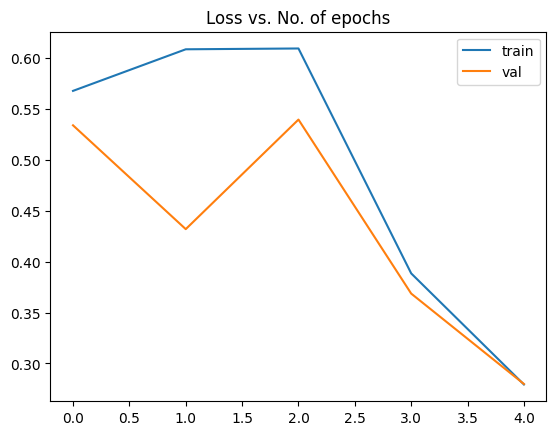

In [ ]:
plt.title('Loss vs. No. of epochs')
plt.plot(train_losses[:15], label='train')
plt.plot(val_losses[:15], label='val')
plt.legend()
#plt.savefig('graph/vit-lossval.png')
plt.show()
plt.close()

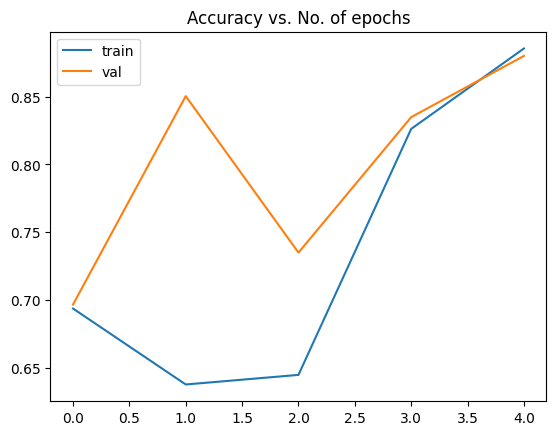

In [ ]:
plt.title('Accuracy vs. No. of epochs')
plt.plot(train_accs[:15], label='train')
plt.plot(val_accs[:15], label='val')
plt.legend()
#plt.savefig('graph/vit-lossval.png')
plt.show()
plt.close()

## Testing

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    # test_ds.classes[label]
    return test_ds.classes[preds]

In [ ]:
# Test Data transforms
test_tfms = tt.Compose([tt.Resize((224, 224)), tt.ToTensor(), tt.Normalize(*stats)])

# load Dataset from folder
test_ds = ImageFolder(data_dir+'/test', test_tfms)

# PyTorch data loaders
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=False)

# Move data loaders to device
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def t_evaluate(model, test_dl):
    #model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(test_dl):
            data = data #.to(device)
            label = label #.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_dl)
            epoch_val_loss += val_loss / len(test_dl)

    return {'test_loss': epoch_val_loss.item(), 'test_acc': epoch_val_accuracy.item()}

In [ ]:
t_result = t_evaluate(model, test_dl)
t_result

In [ ]:
def test_model(model, test_dl):
    CM=0
    #model.eval()
    with torch.no_grad():
        for data, label in tqdm(test_dl):
            data = data #.to(device)
            labels = label #.to(device)

            outputs = model(data) #file_name
            preds = torch.argmax(outputs.data, 1)
            CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0,1])

        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)

        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print()
        print('Confusion Matirx : ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
        print()

    return acc, CM

acc, CM = test_model(model, test_dl)
print(acc)
print(CM)

In [ ]:
#del test_dl

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[1100]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
from random import randrange
img, label = test_ds[randrange(0,1144)]
print(img.shape)
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))